# Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    

In [3]:
stations_df = pd.read_csv('saans/data/stations.csv')
daily_recordings = pd.read_csv('saans/data/station_day.csv')
station_coords = pd.read_csv('saans/data/station_coords_manual.csv')

In [4]:
delhi_stations = stations_df[stations_df['City'] == 'Delhi']['StationId'].tolist()

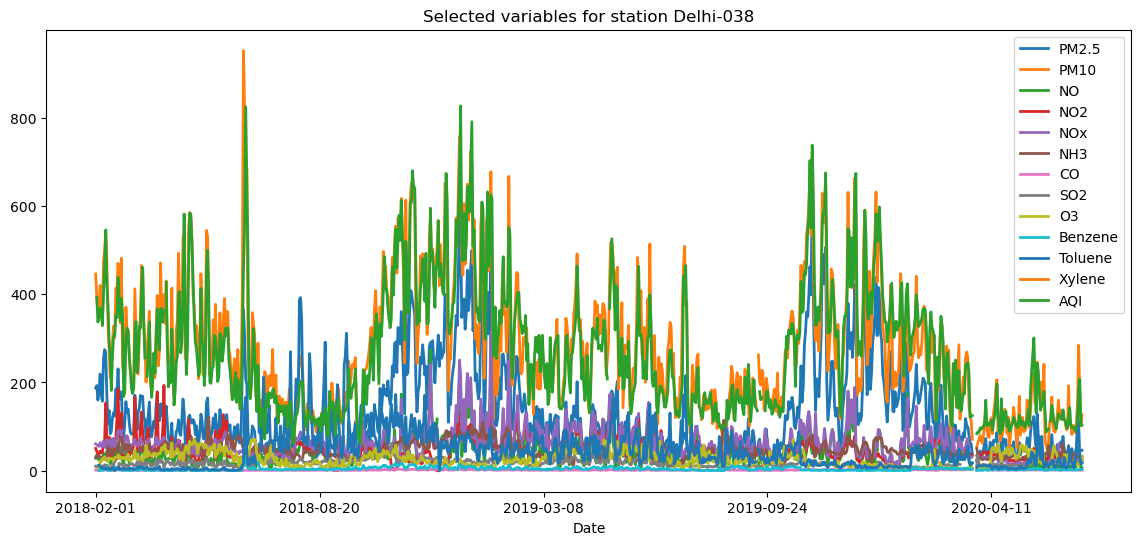

In [8]:
dl_station_daily = daily_recordings[daily_recordings['StationId'] == 'DL038']
dl_station_daily.set_index('Date', inplace=True)
dl_station_daily.plot(figsize=(14,6), linewidth=2)
plt.title('Selected variables for station Delhi-038')
plt.show()

In [9]:
df_container = []

for stationId in delhi_stations:
    print(stationId)
    this_station_df = daily_recordings[daily_recordings['StationId'] == stationId].copy()
    this_station_df['PM2.5_average'] = this_station_df['PM2.5'].rolling(window=10, min_periods=2, center=True).mean()
    this_station_df = this_station_df[['StationId', 'Date', 'PM2.5_average']]
    df_container.append(this_station_df)

    print(this_station_df['Date'].min(), this_station_df['Date'].max())
    #print(this_station_df)

DL001
2018-11-11 2020-07-01
DL002
2015-04-04 2020-07-01
DL003
2018-02-01 2020-07-01
DL004
2017-09-07 2020-07-01
DL005
2018-07-04 2020-07-01
DL006
2017-08-31 2020-01-01
DL007
2015-01-01 2020-07-01
DL008
2015-01-01 2020-07-01
DL009
2018-02-01 2020-07-01
DL010
2018-02-01 2020-07-01
DL011
2016-04-01 2020-07-01
DL012
2017-08-31 2020-07-01
DL013
2015-01-01 2020-07-01
DL014
2015-01-03 2020-07-01
DL015
2018-02-01 2020-07-01
DL016
2018-02-01 2020-07-01
DL017
2017-09-07 2020-07-01
DL018
2018-02-01 2020-07-01
DL019
2015-04-09 2020-07-01
DL020
2018-07-03 2020-07-01
DL021
2015-01-01 2020-07-01
DL022
2018-02-01 2020-07-01
DL023
2018-02-01 2020-07-01
DL024
2018-02-01 2020-07-01
DL025
2017-08-31 2020-07-01
DL026
2018-02-01 2020-07-01
DL027
2018-02-01 2020-07-01
DL028
2015-04-07 2020-07-01
DL029
2018-07-03 2020-07-01
DL030
2017-09-06 2020-07-01
DL031
2015-04-04 2020-07-01
DL032
2018-02-01 2020-07-01
DL033
2015-01-01 2020-07-01
DL034
2016-11-03 2020-07-01
DL035
2018-02-01 2020-07-01
DL036
2018-07-03 202

In [10]:
combined_df = pd.concat(df_container)

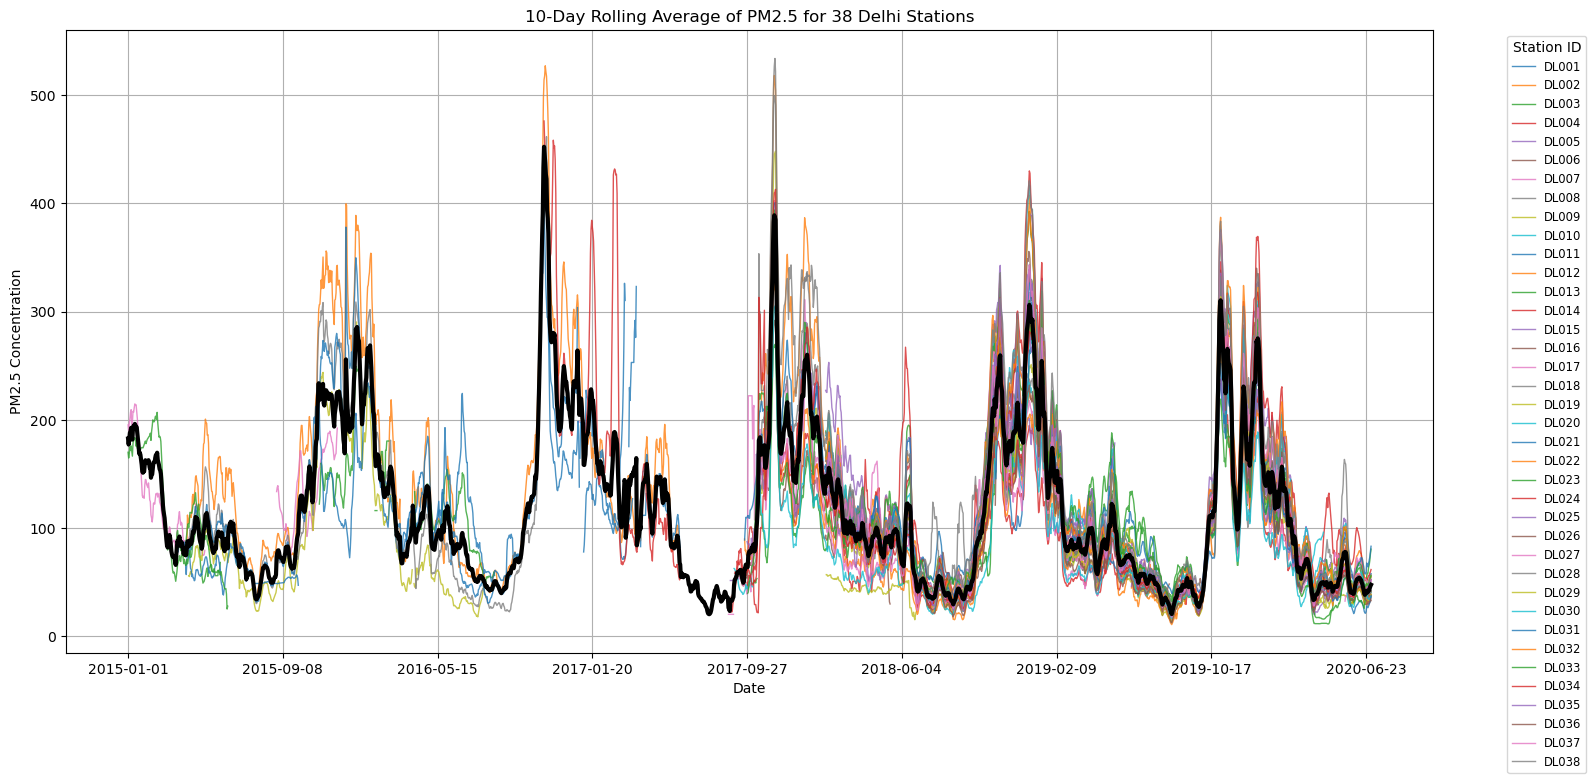

In [12]:
pivot_df = combined_df.pivot(index='Date', columns='StationId', values='PM2.5_average')

plt.figure(figsize=(16, 8))
pivot_df.plot(ax=plt.gca(), alpha=0.8, linewidth=1)  # one line per station

daily_avg_pm25 = pivot_df.mean(axis=1, skipna=True)
daily_avg_pm25.plot(linewidth=3, color='black')

plt.title('10-Day Rolling Average of PM2.5 for 38 Delhi Stations')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig('saans/delhi_lineplot.png')
plt.show()

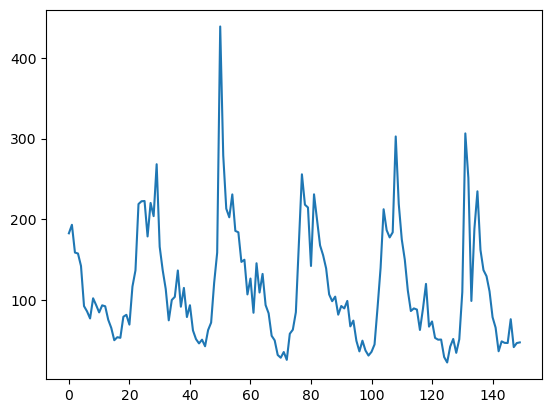

In [13]:
interp_length = 150
y_pm = daily_avg_pm25
x_pm = np.linspace(0, 100, len(y_pm))
x_interp = np.linspace(0, 100, interp_length)
pm_interp = np.interp(x_interp, x_pm, y_pm)

plt.plot(pm_interp)

# Modifications



There are a few ways in which I want to modify the sound:
1. The pitch of the out-of-tune drones will be (right note + PM_interpolated squared)
2. The volume of all the drones will be (lfo + PM_scaled * faster lfo) 
3. A drone pitched at an octave and tritone (2 * sqrt 2), whose volume is 0 for PM < 200, and PM_scaled for PM > 200

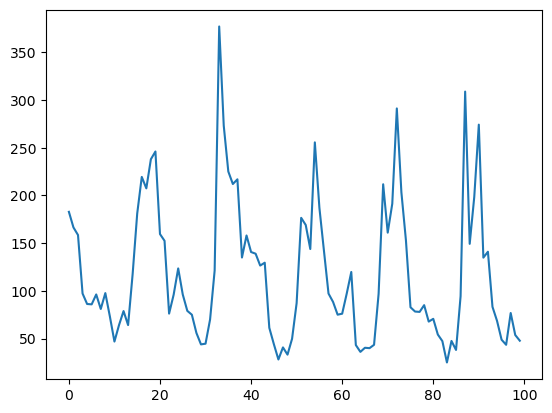

In [14]:
# Residuals for out-of-tune drones

# First, interpolate to reasonable amount to prevent clipping

interp_length = 100
y_pm = daily_avg_pm25
x_pm = np.linspace(0, 100, len(y_pm))
x_interp = np.linspace(0, 100, interp_length)
pm_interp_100 = np.interp(x_interp, x_pm, y_pm)

plt.plot(pm_interp_100)

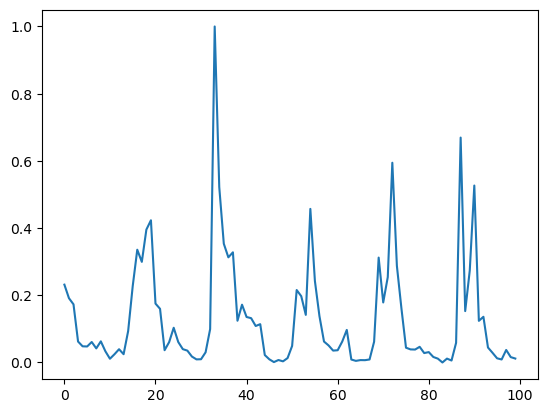

In [15]:
# Next, square it and scale it
pitch_residual = pm_interp_100 ** 2
pitch_residual = (pitch_residual - np.min(pitch_residual)) / (np.max(pitch_residual) - np.min(pitch_residual))
plt.plot(pitch_residual)

Text(0.5, 1.0, '2009')

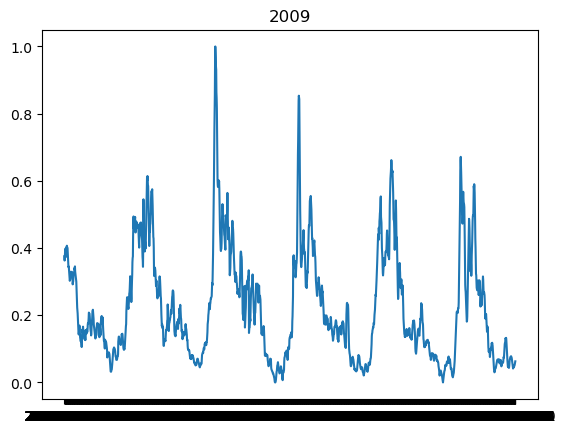

In [16]:
# Volumes of HFO - (0,1) for now, scale later

pm25_scaled = (daily_avg_pm25 - np.min(daily_avg_pm25)) / (np.max(daily_avg_pm25) - np.min(daily_avg_pm25))

plt.plot(pm25_scaled)
plt.title(len(pm25_scaled))

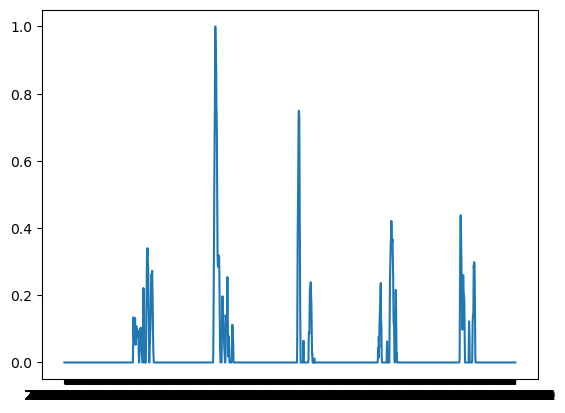

In [17]:
# Tritone volume - 0 for PM < 200, 0-1 for PM >= 200
tritone_vol = daily_avg_pm25 - 200
tritone_vol[tritone_vol < 0] = 0
tritone_vol = tritone_vol / np.max(tritone_vol)

plt.plot(tritone_vol)

# Music


In [18]:
from resources import *
seconds = 7 * 60

Initializing resources...
... packages imported!
... resources initialized!


In [19]:
# The volume oscillator
pm25_x = np.linspace(0, 1, len(pm25_scaled))
x_drone = np.linspace(0, 1, len(lfo(0.1, seconds)))
pm25_osc = np.interp(x_drone, pm25_x, pm25_scaled)

def vol_oscillator(rate, phase):
    oscillator = lfo(rate, seconds, phase) + pm25_osc * lfo(10, seconds)

    return oscillator
    #print(len(oscillator), np.min(oscillator), np.max(oscillator)) # Goal: -1 to 1
    #plt.plot(oscillator[int(0.6 * (10 ** 7)):int(0.7 * (10 ** 7))])

In [ ]:
# The drone

fundamentalPitch = notename_to_hertz('D-3')

sine_low = 2 * sineWave(fundamentalPitch / 2, seconds)
sine_fundamental = 2 * sineWave(fundamentalPitch, seconds)


squareVol = 0.4 + 0.05 * vol_oscillator(0.1, np.pi/6) #np.sin(np.pi * volx / SAMPLE_RATE + np.pi/5)
squareFifthDown = squareVol * squareWave(1.5 * fundamentalPitch - 1, seconds)
squareFifthUp = squareVol * squareWave(1.5 * fundamentalPitch + 1, seconds)
squareFifth = squareFifthDown + squareFifthUp

sawtoothVol = 0.4 - 0.05 * vol_oscillator(0.07, np.pi/3) #np.sin(np.pi * volx / SAMPLE_RATE + 2 * np.pi/5)
sawtoothFifthDown = sawtoothVol * sawtoothWave(1.5 * fundamentalPitch - 0.9, seconds)
sawtoothFifthUp = sawtoothVol * sawtoothWave(1.5 * fundamentalPitch + 0.9, seconds)
sawtoothFifth = sawtoothFifthDown + sawtoothFifthUp

sineVol = 0.3 - 0.05 *  vol_oscillator(0.06, np.pi/2) #np.sin(np.pi * volx / SAMPLE_RATE + 2 * np.pi/5)
sineFifthDown = sineVol * sineWave(1.5 * fundamentalPitch - 0.9, seconds)
sineFifthUp = sineVol * sineWave(1.5 * fundamentalPitch + 0.9, seconds)
sineFifth = sineFifthDown + sineFifthUp

squareVol = 0.4 - 0.05 * vol_oscillator(0.09, np.pi) #np.sin(np.pi * volx / SAMPLE_RATE + 4 * np.pi/5)
squareOctaveDown = squareVol * squareWave(2 * fundamentalPitch - 0.8, seconds)
squareOctaveUp = squareVol * squareWave(2 * fundamentalPitch + 0.8, seconds)
squareOctave = squareOctaveDown + squareOctaveUp

sawtoothVol = 0.4 + 0.05 * vol_oscillator(0.05, 2 * np.pi/3) #np.sin(np.pi * volx / SAMPLE_RATE + 3 * np.pi/5)
sawtoothOctaveDown = sawtoothVol * sawtoothWave(2 * fundamentalPitch - 0.7, seconds)
sawtoothOctaveUp = sawtoothVol * sawtoothWave(2 * fundamentalPitch + 0.7, seconds)
sawtoothOctave = sawtoothOctaveDown + sawtoothOctaveUp

sineVol = 0.3 - 0.05 * vol_oscillator(0.06, 5 * np.pi/6) #np.sin(np.pi * volx / SAMPLE_RATE + 2 * np.pi/5)
sineOctaveDown = sineVol * sineWave(2 * fundamentalPitch - 0.5, seconds)
sineOctaveUp = sineVol * sineWave(2 * fundamentalPitch + 0.5, seconds)
sineOctave = sineOctaveDown + sineOctaveUp

#triangleVol = 0.15 - 0.05 * lfo(0.08, seconds, phase=np.pi/5) #np.sin(np.pi * volx / SAMPLE_RATE + 5 * np.pi/5)
#triangle = triangleVol * triangleWave(4 / 3 * fundamentalPitch, seconds)

sumL = sine_low + sine_fundamental + 0.6 * squareFifth + 0.4 * sawtoothFifth + 0.7 * sineFifth + 0.1 * squareOctave + 0.9 * sawtoothOctave + 0.3 * sineOctave
sumR = sine_low + sine_fundamental + 0.4 * squareFifth + 0.6 * sawtoothFifth + 0.3 * sineFifth + 0.9 * squareOctave + 0.1 * sawtoothOctave + 0.7 * sineOctave

stereo_sound = np.column_stack((sumL, sumR))

#write('saans/temp_audio/stereo_drone.wav', SAMPLE_RATE, stereo_sound)

In [23]:
len(sumL), np.max(sumL), len(sumR), np.max(sumR)

(18522000, 0.04974362029281858, 18522000, 0.05054282404506126)

In [ ]:
# Out-of-tune drones
detuned_durations = np.ones_like(pitch_residual) * (seconds / len(pitch_residual))

octave_up_vector = 4 * fundamentalPitch + 60 * pitch_residual
octave_up_detuned = 1.5 * glissandoMelody('square', octave_up_vector, detuned_durations)
octave_down_vector = 4 * fundamentalPitch - 40 * pitch_residual
octave_down_detuned = glissandoMelody('square', octave_down_vector, detuned_durations)

fifth_up_vector = 3 * fundamentalPitch + 30 * pitch_residual
fifth_up_detuned = glissandoMelody('square', fifth_up_vector, detuned_durations)
fifth_down_vector = 3 * fundamentalPitch - 50 * pitch_residual
fifth_down_detuned = 1.5 * glissandoMelody('square', fifth_up_vector, detuned_durations)

detuned_L = 0.25 * octave_up_detuned + 0.75 * octave_down_detuned + 0.25 * fifth_up_detuned + 0.75 * fifth_down_detuned
detuned_R = 0.75 * octave_up_detuned + 0.25 * octave_down_detuned + 0.75 * fifth_up_detuned + 0.25 * fifth_down_detuned

# Volumes: 0 --> 0.3, 1 --> 0.5. First 5%: fade in to 0.3
pm25_x = np.linspace(0, 1, len(pm25_scaled))
x_drone = np.linspace(0, 1, len(detuned_L))
pm25_drone_length = np.interp(x_drone, pm25_x, pm25_scaled)

detunedVol = 0.2 + 0.3 * pm25_drone_length
fade_in_idx = int(0.07 * len(pm25_drone_length))
fade_in = np.linspace(0, 0.2, fade_in_idx)
detunedVol[:fade_in_idx] = fade_in

stereo_detuned = np.column_stack((detunedVol * detuned_L, detunedVol * detuned_R))

#write('saans/temp_audio/stereo_detuned.wav', SAMPLE_RATE, stereo_detuned)

stereo_detuned.shape, np.min(stereo_detuned), np.max(stereo_detuned)

((18336780, 2), -0.012498962429079625, 0.012498508890818603)

In [ ]:
# Bass note - change mix

duration = 420
sineBass = 2 * sineWave(fundamentalPitch / 2, duration) + 2 * sineWave(1.5 * fundamentalPitch / 2, duration) + 2 * sineWave(fundamentalPitch, duration)
sawtoothBass = 0.5 * sawtoothWave(fundamentalPitch / 2, duration) + 0.5 * sawtoothWave(1.5 * fundamentalPitch / 2, duration) + 0.5 * sawtoothWave(fundamentalPitch, duration)

stereo_bass = np.column_stack((sineBass * (1 - pm25_osc), sawtoothBass * pm25_osc))

#bassMix = sawtoothBass * pm25_osc + sineBass * (1 - pm25_osc)

#write('saans/temp_audio/stereo_bass.wav', SAMPLE_RATE, stereo_bass)

np.min(stereo_bass), np.max(stereo_bass)

(-0.05501384697961042, 0.05501387337589058)

In [ ]:
# Tritones

# Interp to 100 first?
testX = np.linspace(0, 1, len(tritone_vol))
testNewX = np.linspace(0, 1, 100)
testInterp = np.interp(testNewX, testX, tritone_vol)

# Then interp to the drone length
tritone_x = np.linspace(0, 1, len(testInterp))
x_drone = np.linspace(0, 1, len(sumL))
tritone_drone_vol = np.interp(x_drone, tritone_x, testInterp)


tritoneDown = 2 * np.sqrt(2) * fundamentalPitch
tritoneUp = 2 * tritoneDown
diss0 = 8 * fundamentalPitch
dissWaves = sawtoothWave(diss0, seconds) + sawtoothWave(diss0 + 5, seconds) + sawtoothWave(diss0 + 10, seconds) + sawtoothWave(diss0 + 15, seconds)

dissWaves_L = sawtoothWave(tritoneUp - 1, seconds) + sawtoothWave(tritoneUp + 1, seconds) + dissWaves
dissWaves_R = sawtoothWave(tritoneDown - 1, seconds) + sawtoothWave(tritoneDown + 1, seconds) + dissWaves

#tritones = tritone_drone_vol * tritoneWaves

diss_stereo = np.column_stack((tritone_drone_vol * dissWaves_L, tritone_drone_vol * dissWaves_R))

#write('saans/temp_audio/tritone_peaks.wav', SAMPLE_RATE, diss_stereo)

diss_stereo.shape, np.min(diss_stereo), np.max(diss_stereo)


((18522000, 2), -0.0390296520197423, 0.03901612343431918)

In [28]:
# Combine everything together
maxLength = stereo_detuned.shape[0]
wavesCombined = stereo_sound[:maxLength, :] + stereo_detuned + 0.8 * diss_stereo[:maxLength, :] + stereo_bass[:maxLength, :]

In [29]:
# Last-minute volume adjustments
silence_5 = np.zeros(int(5 * SAMPLE_RATE))
fadein = np.linspace(0, 1, int(5 * SAMPLE_RATE))
fadeout = np.linspace(1, 0, int(20 * SAMPLE_RATE))

totalVolArr = np.ones(maxLength)
totalVolArr[0:len(silence_5)] = silence_5
totalVolArr[len(silence_5):(len(silence_5) + len(fadein))] = fadein
totalVolArr[-len(fadeout):] = fadeout

wavesAndVolume = wavesCombined * totalVolArr[:, np.newaxis]

In [ ]:
# Opening notes

def tanpura_note(pitch):
    a = 0.5 * sineWave(pitch / 2, 10)
    b = sineWave(pitch, 10)
    c = squareWave(pitch - 0.7, 10) + squareWave(pitch + 0.7, 10)
    d = sawtoothWave(pitch - 0.7, 10) + sawtoothWave(pitch + 0.7, 10)

    adsr = generate_adsr_envelope(10 * SAMPLE_RATE, 'val', 0.01 * SAMPLE_RATE, 0.05 * SAMPLE_RATE, 0.8, 5 * SAMPLE_RATE)
    
    return adsr * (a + b + c + d)


note1 = tanpura_note(fundamentalPitch * 1.5)
note2 = tanpura_note(fundamentalPitch * 2)
note3 = tanpura_note(fundamentalPitch)

#write('saans/temp_audio/tanpura_note.wav', SAMPLE_RATE, note1)


In [ ]:
openingNotes_L = np.zeros(maxLength)
openingNotes_R = np.zeros(maxLength)

sec1 = SAMPLE_RATE
sec2 = 2 * SAMPLE_RATE
sec3 = 3 * SAMPLE_RATE
sec4 = 4 * SAMPLE_RATE

openingNotes_L[sec1:sec1 + len(note1)] = note1
openingNotes_L[sec2:sec2 + len(note2)] = 0.66 * note2
openingNotes_L[sec3:sec3 + len(note2)] = 0.33 * note2

openingNotes_R[sec2: sec2 + len(note2)] = 0.33 * note2
openingNotes_R[sec3: sec3 + len(note2)] = 0.66 * note2
openingNotes_R[sec4: sec4 + len(note3)] = note3

opening_notes = np.column_stack((openingNotes_L, openingNotes_R))

#write('saans/temp_audio/opening_notes.wav', SAMPLE_RATE, opening_notes)

In [32]:
write('saans/saans.wav', SAMPLE_RATE, 20 * (wavesAndVolume + opening_notes))

# Video

In [33]:
pivot_df.head()

StationId,DL001,DL002,DL003,DL004,DL005,DL006,DL007,DL008,DL009,DL010,...,DL029,DL030,DL031,DL032,DL033,DL034,DL035,DL036,DL037,DL038
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,195.404000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,189.726667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,196.878571,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,201.203750,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,207.110000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
station_coords.head()

,StationId,StationName,Lat,Lon
0,DL001,"Alipur, Delhi - DPCC",28.796313,77.136726
1,DL002,"Anand Vihar, Delhi - DPCC",28.649498,77.310067
2,DL003,"Ashok Vihar, Delhi - DPCC",28.694179,77.175365
3,DL004,"Aya Nagar, Delhi - IMD",28.470083,77.129897
4,DL005,"Bawana, Delhi - DPCC",28.803479,77.048417


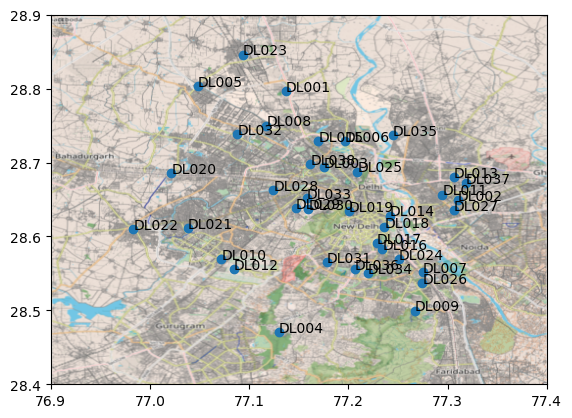

In [36]:
map_img = plt.imread('saans/data/delhi_map.png')

extent = (76.9, 77.4, 28.4, 28.9)

fig, ax = plt.subplots()

plt.imshow(map_img, extent=extent, aspect='auto')

scatter = ax.scatter(station_coords['Lon'], station_coords['Lat'])

for i, row in station_coords.iterrows():
    ax.annotate(row['StationId'], xy=(row['Lon'], row['Lat']))

#for i, txt in enumerate(station_coords['StationId']):
#    ax.annotate(txt, (station_coords['Lon'][i], station_coords['Lat'][i]))

In [37]:
geo_df = combined_df.merge(station_coords, on='StationId', how='left')
geo_df = geo_df[~np.isnan(geo_df['PM2.5_average'])]
geo_df

,StationId,Date,PM2.5_average,StationName,Lat,Lon
0,DL001,2018-11-11,202.428000,"Alipur, Delhi - DPCC",28.796313,77.136726
1,DL001,2018-11-12,193.061667,"Alipur, Delhi - DPCC",28.796313,77.136726
2,DL001,2018-11-13,189.307143,"Alipur, Delhi - DPCC",28.796313,77.136726
3,DL001,2018-11-14,192.961250,"Alipur, Delhi - DPCC",28.796313,77.136726
4,DL001,2018-11-15,196.734444,"Alipur, Delhi - DPCC",28.796313,77.136726
...,...,...,...,...,...,...
45355,DL038,2020-06-27,43.263000,"Wazirpur, Delhi - DPCC",28.697810,77.161715
45356,DL038,2020-06-28,42.525556,"Wazirpur, Delhi - DPCC",28.697810,77.161715
45357,DL038,2020-06-29,43.331250,"Wazirpur, Delhi - DPCC",28.697810,77.161715
45358,DL038,2020-06-30,44.725714,"Wazirpur, Delhi - DPCC",28.697810,77.161715


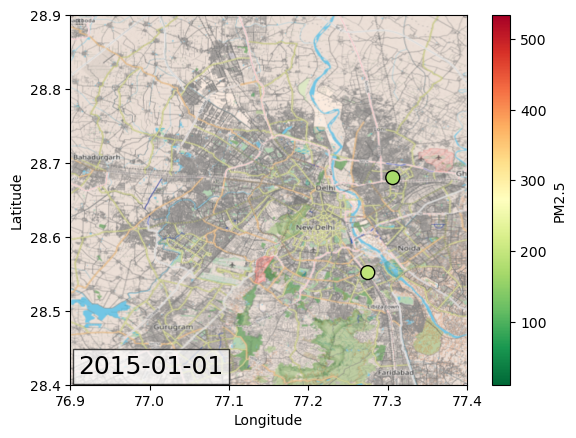

In [39]:
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors

# Set up map
fig, ax = plt.subplots()
map_img = plt.imread('saans/data/delhi_map.png')
extent = (76.9, 77.4, 28.4, 28.9)
ax.imshow(map_img, extent=extent, aspect='auto')

# Set up colors
norm = colors.Normalize(vmin=geo_df['PM2.5_average'].min(), vmax=geo_df['PM2.5_average'].max())
cmap = plt.colormaps['RdYlGn_r']

# Each frame: one day
dates = sorted(geo_df['Date'].dropna().unique())

# Initialize first day
day_df = geo_df[geo_df['Date'] == dates[0]]
sc = ax.scatter(
    day_df['Lon'], day_df['Lat'], c=day_df['PM2.5_average'], cmap=cmap, norm=norm, s=100, edgecolor='black', label='Stations')
date_text = ax.text(0.02, 0.03, str(dates[0]), transform=ax.transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.7))

# Set up plot
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('')

cbar = plt.colorbar(sc, ax=ax, label='PM2.5')

In [40]:
def update(frame):
    day = dates[frame]
    print(day)
    day_df = geo_df[geo_df['Date'] == day]
    sc.set_offsets(day_df[['Lon', 'Lat']].values)
    sc.set_array(day_df['PM2.5_average'].values)
    date_text.set_text(str(dates[frame]))
    return (sc, date_text)


In [41]:
num_dates = len(dates)
num_seconds = len(wavesAndVolume) / SAMPLE_RATE
dates_per_sec = num_dates / num_seconds

In [42]:
from matplotlib.animation import FFMpegWriter
ani = FuncAnimation(fig, update, frames=len(dates), interval=100)
ani.save('saans/delhi_animation.mp4', writer=FFMpegWriter(fps=dates_per_sec))

2015-01-01
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31